In [1]:
using Plots, LinearAlgebra, DifferentialEquations, LaTeXStrings, FileIO, JLD2, SparseArrays, Distances, Statistics, Measures, CSV, DataFrames, Flux

workingdirectory = "/mocktest/"

"/Users/dustin/Desktop/julia/research_gw_Mock/"

In [2]:
const γ     = 5.0/3.0             # Equation of State, Mono-atomic Ideal Gas
const mu    = 0.6                 # Solar metallicity 
const kb    = 1.380649e-16        # Boltzmann constant [erg/K]
const kbKeV = 8.617333e-8         # Boltzmann constant [KeV/K]
const Msun  = 1.9884754e33        # Solar mass [g]
const yr    = 3.155692e7          # Year [s] 
const kyr   = 3.155692e10         # Kiloyear [s] 
const kpc   = 3.0856775e21        # Kiloparsec [cm]
const pc    = 3.0856775e18        # Parsec [cm]
const mp    = 1.6726219e-24       # Proton mass
const kev_to_erg = 1.60219e-09    # Conversion of KeV to erg 

# Even though we're using float64 and can handle cgs units (1/kpc^3), we'll still
# convert to so-called code units in the system of ODEs. This helps the numerical solver. 

const LENGTH_UNIT   = kpc 
const TIME_UNIT     = kyr 
const MASS_UNIT     = Msun 
const VELOCITY_UNIT = LENGTH_UNIT / TIME_UNIT
const DENSITY_UNIT  = MASS_UNIT / LENGTH_UNIT^3
const PRESSURE_UNIT = MASS_UNIT * VELOCITY_UNIT^2 / LENGTH_UNIT^3 
const ENERGY_UNIT   = MASS_UNIT * VELOCITY_UNIT^2 

1.9012186785580059e55

# Load in constants and observation data 

Length of data  array: 44
Length of model array: 861
Ignore the y axis, its just to illustrate spacing, and confirm the indexing on the model and data is correct.


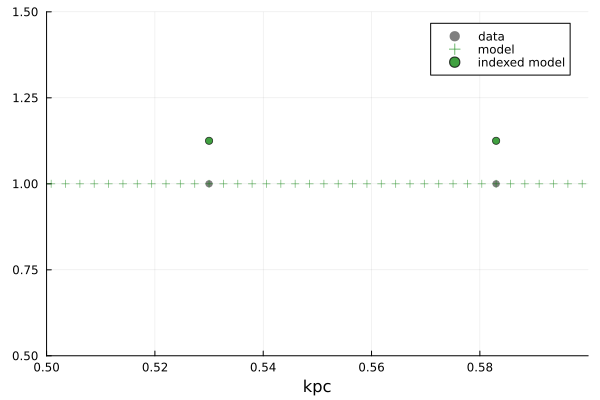

In [3]:
# Define constants in cgs units unless specified otherwise 
begin
    const γ     = 5.0/3.0             # Equation of State, Mono-atomic Ideal Gas
    const mu    = 0.6                 # Solar metallicity 
    const kb    = 1.380649e-16        # Boltzmann constant [erg/K]
    const kbKeV = 8.617333e-8         # Boltzmann constant [KeV/K]
    const Msun  = 1.9884754e33        # Solar mass [g]
    const yr    = 3.155692e7          # Year [s] 
    const kyr   = 3.155692e10         # Kiloyear [s] 
    const kpc   = 3.0856775e21        # Kiloparsec [cm]
    const pc    = 3.0856775e18        # Parsec [cm]
    const mp    = 1.6726219e-24       # Proton mass
    const kev_to_erg = 1.60219e-09    # Conversion of KeV to erg 

    # Even though we're using float64 and can handle cgs units (1/kpc^3), we'll still
    # convert to so-called code units in the system of ODEs. This helps the numerical solver. 

    const LENGTH_UNIT   = kpc 
    const TIME_UNIT     = kyr 
    const MASS_UNIT     = Msun 
    const VELOCITY_UNIT = LENGTH_UNIT / TIME_UNIT
    const DENSITY_UNIT  = MASS_UNIT / LENGTH_UNIT^3
    const PRESSURE_UNIT = MASS_UNIT * VELOCITY_UNIT^2 / LENGTH_UNIT^3 
    const ENERGY_UNIT   = MASS_UNIT * VELOCITY_UNIT^2 
end 

# Load in processed data 
begin 
    df = CSV.File(workingdirectory*"data/north_data.csv") |> DataFrame

    # Extract columns as arrays
    x_data = df[!, :z_N] |> collect
    T_data = df[!, :T_N] |> collect
    n_data = df[!, :n_N] |> collect
    A_data = df[!, :A_N] |> collect 
    dlogAdx_data = df[!, :dLA_N] |> collect
    K_data = T_data ./ n_data.^(2.0/3.0)
end 

# Define initial conditions, these are pre-calculated from the Python jupyter notebook 
begin 
    # These x-values are the same as the data's. 
    const x_i      = x_data[1]               # start
    const x_f      = x_data[end]             # stop
    const nx       = length(x_data)          # number steps between start and stop 
    const dx       = (x_f - x_i) / (nx-1)    # dx required  
    const xspan    = [x_i,x_f]
    const x_range  = range(start=x_i, stop=x_f, step=dx)
    const x_values = collect(x_range); 

    # This is the range and span we evaluate over for our models. 
    # This additional resolution is required to resolve cooling. 
    # fdx is the factor of model resolution relative to data resolution. 

    const fdx       = 20.0
    const dx2       = dx / fdx  
    const x_range2  = range(start=x_i,stop=x_f, step=dx2)
    const x_values2 = collect(x_range2)

    # indexes to compare the higher reslution to the data 
    indexes = 1:Int64(fdx):length(x_values2)

    println("Length of data  array: $(length(x_data))")
    println("Length of model array: $(length(x_range2))")

    # initial condition 
    # cgs 
    vInf = 1835e5   # v_Inf = 1853 km/s 

    v0 = vInf 
    n0 = n_data[1] 
    T0 = T_data[1] 
    ρ0 = n0 * mu * mp 
    P0 = n0 * kb * T0 
    u0 =  [v0,ρ0,P0]
    u0_CU = [v0/VELOCITY_UNIT,ρ0/DENSITY_UNIT,P0/PRESSURE_UNIT]
    xspan_CU = xspan / LENGTH_UNIT
    dx_CU = dx / LENGTH_UNIT 

    println("Ignore the y axis, its just to illustrate spacing, and confirm the indexing on the model and data is correct.")
    # Plot the resolutions for illustrative purposes. 
    # black is data resolution, blue is model resolution  
    plot(x_data,x_data ./ x_data,seriestype=:scatter,marker=:circle,markeralpha=0.5,xlims=(0.5,0.6),ylims=(0.5,1.5),c=:black,label="data")
    plot!(x_values2,x_values2 ./ x_values2,seriestype=:scatter,marker=:cross,c=:green,markeralpha=0.5,xlabel="kpc",label="model")
    plot!(x_values2[indexes], x_values2[indexes]./x_values2[indexes] .* 1.125,seriestype=:scatter,marker=:circle,c=:green,markeralpha=0.75,label="indexed model")
end 

In [7]:
begin
    function gravity_function(r)
        σ = 200e5       # cm/s 
        return σ^2 / r  # cm/s^2 
    end 
    plot(gravity_function.(x_range*LENGTH_UNIT)./(LENGTH_UNIT/TIME_UNIT^2))
end

begin
    function μ_function(r) 
        μ0 = 1e1
        a = 1.5
        Δ = 4.0
        Γ = -4.0 
        mudot = μ0 * a^Δ / (r^Δ * (1 + r/a)^(Γ-Δ))
        return  mudot  
    end 
    plot(x_values2,log10.(μ_function.(x_range2)))
end
    

function d_area_function(r) 
    A0 = 0.25                         # input in code_units 
    x_break = 1.0
    return 2 * A0 * r / x_break^2 
end 


begin
    function Λ_function(T_cgs)
        # This if-statement is required for some random solutions that predict negative T. 
        # I've never seen negative T in solutions that didn't fail, this must be something to do with the error estimation of DifferentialEquations.jl
        if T_cgs < 0
            Λ = 0.0 
            return Λ
        else
            logT = log10(T_cgs)
            if logT <= 4.0
            Λ = 0.0 
            elseif 4.0 < logT && logT <= 5.9
                Λ = 10^(-1.3 * (logT-5.25)^2 - 21.25)
            elseif 5.9 < logT && logT <= 7.4
                Λ = 10^(0.7 * (logT-7.1)^2 - 22.8)
            else
                Λ = 10^(0.45 * logT - 26.065)
            end
            return Λ
        end 
    end   

    T_range = range(start=1e4, stop=1e8, length=Int64(1e5))
    Λ_values = Λ_function.(T_range)  
    plot(log10.(T_range),log10.(Λ_values),xlabel=L"$ \log_{10}( T \ \mathrm{[K]})$",ylabel=L"$ \log_{10}( Λ \ \mathrm{[ergs \, cm^3 \, s^{-1}]})$")
end


begin
    function dlogAdx_interpolation(x, x_values, dlogAdx)
        idx = searchsortedlast(x_values, x)

        # If x is outside the range of x_values, return the edge values of dlogAdx
        if idx == 0
            return dlogAdx[1]
        elseif idx == length(x_values)
            return dlogAdx[end]
        end

        # Calculate the slope between the two surrounding points
        slope = (dlogAdx[idx+1] - dlogAdx[idx]) / (x_values[idx+1] - x_values[idx])

        # Return the interpolated value
        return dlogAdx[idx] + slope * (x - x_values[idx])
    end
     # Plot the surface area expansion rate for the higher resolution spatial points 
     interp_values = [dlogAdx_interpolation(x, x_data, dlogAdx_data) for x in x_range2]
    
     plot(x_data,dlogAdx_data/(1/LENGTH_UNIT),seriestype=:scatter,market=:circle,markeralpha=0.5,c=:black,xlabel=L"$x\, \mathrm{[kpc]}$",ylabel=L"$d\log A / dx \, \mathrm{[kpc^{-1}]}$")
     plot!(x_range2,interp_values/(1/LENGTH_UNIT),seriestype=:scatter,marker=:cross,markeralpha=0.5)
end

function extract_cgs_solution(solution)
    v = solution[1,:] * VELOCITY_UNIT
    ρ = solution[2,:] * DENSITY_UNIT
    P = solution[3,:] * PRESSURE_UNIT
    n = ρ / (mu*mp)
    T = P ./ (n*kb)
    c = sqrt.(γ * P ./ ρ)
    K = T ./ n.^(2/3)
    M = v ./ c 
    return v, ρ, P, n, T, c, K, M
end 

function nonsph_wind!(du,u,p,r)
    v, ρ, P = u

    n = ρ / (mu*(mp/MASS_UNIT))

    r_cgs = r * LENGTH_UNIT 
    P_cgs = P * PRESSURE_UNIT
    n_cgs = ρ * DENSITY_UNIT / (mu*mp)
    T_cgs = P_cgs ./ (n_cgs * kb)

    # Additional physics 
    Λ       = Λ_function(T_cgs) / (ENERGY_UNIT * LENGTH_UNIT^3 / TIME_UNIT) 
    #dlogAdr = dlogAdx_interpolation(r, x_data, dlogAdx_data) / (1/LENGTH_UNIT)
    dlogAdr = d_area_function(r)
    G       = gravity_function(r_cgs) / (LENGTH_UNIT / TIME_UNIT^2)
    μ       = μ_function(r)  
    
    du[1] = dvdr = ((γ*P*v/(ρ))*dlogAdr + ((γ-1.0)*Λ*n^2.0/ρ) - ((γ+1.0)*μ*v^2.0/(2.0*ρ)) - (G*v))/(v^2.0-γ*P/ρ)
    du[2] = dρdr = (μ/v) - (ρ)*(dlogAdr) - (ρ/v)*(dvdr) 

    if T_cgs <= 1e4   # Temperature floor 1e4K -> switch to isothermal wind equation of state 
        return du[3] = dPdr = (P/ρ)*dρdr  
    else          
        return du[3] = dPdr = (γ*P/ρ)*dρdr - ((γ-1.0)*n^2.0*Λ/v) + (γ-1.0)*(μ/v)*(v^2.0/2.0 - (γ/(γ-1.0))*(P/ρ))
    end 
end

2.06952229948243


# Load in trained neural ODE solutions, neural network parameters, and calculated loss. 

Then extract solutions alongside learned mass-loading function by reconstructing nn with trained parameters.

In [8]:
function extract_optimized_solutions(predictions,string)
    if string == "start"
        v = predictions[1][1,:] * VELOCITY_UNIT
        ρ = predictions[1][2,:] * DENSITY_UNIT
        P = predictions[1][3,:] * PRESSURE_UNIT
        n = ρ ./ (mu * mp)
        T = P ./ (n * kb)
        c = sqrt.(γ * P ./ ρ)
        K = T ./ n.^(2/3)
        M = v ./ c 
    elseif string == "end"
        v = predictions[end][1,:] * VELOCITY_UNIT
        ρ = predictions[end][2,:] * DENSITY_UNIT
        P = predictions[end][3,:] * PRESSURE_UNIT
        n = ρ ./ (mu * mp)
        T = P ./ (n * kb)
        c = sqrt.(γ * P ./ ρ)
        K = T ./ n.^(2/3)
        M = v ./ c 
    end
    return v, ρ, P, n, T, c, K, M
end 

In [21]:
LOSS_ADAM = load_object(workingdirectory*"/output/l_ADAM.jld2")
PRED_ADAM = load_object(workingdirectory*"/output/sol_ADAM.jld2")
PARS_ADAM = load_object(workingdirectory*"/output/p_ADAM.jld2")

LOSS_BFGS = load_object(workingdirectory*"/output/l_BFGS.jld2")
PRED_BFGS = load_object(workingdirectory*"/output/sol_BFGS.jld2")
PARS_BFGS = load_object(workingdirectory*"/output/p_BFGS.jld2")


function extract_optimized_solutions(predictions,string)
    if string == "start"
        v = predictions[1][1,:] * VELOCITY_UNIT
        ρ = predictions[1][2,:] * DENSITY_UNIT
        P = predictions[1][3,:] * PRESSURE_UNIT
        n = ρ ./ (mu * mp)
        T = P ./ (n * kb)
        c = sqrt.(γ * P ./ ρ)
        K = T ./ n.^(2/3)
        M = v ./ c 
    elseif string == "end"
        v = predictions[end][1,:] * VELOCITY_UNIT
        ρ = predictions[end][2,:] * DENSITY_UNIT
        P = predictions[end][3,:] * PRESSURE_UNIT
        n = ρ ./ (mu * mp)
        T = P ./ (n * kb)
        c = sqrt.(γ * P ./ ρ)
        K = T ./ n.^(2/3)
        M = v ./ c 
    end
    return v, ρ, P, n, T, c, K, M
end 


# Grab prediction solutions for beginning and end of optimization iterations for final plots. 
# We'll loop through each iteration later below when making a movie. 

v_adam_start, ρ_adam_start, P_adam_start, n_adam_start, T_adam_start, c_adam_start, K_adam_start, M_adam_start = extract_optimized_solutions(PRED_ADAM,"start");
v_bfgs_end, ρ_bfgs_end, P_bfgs_end, n_bfgs_end, T_bfgs_end, c_bfgs_end, K_bfgs_end, M_bfgs_end = extract_optimized_solutions(PRED_BFGS,"end");

# Neural network

Ξ = 64
ann = Chain(  
    Dense(1, Ξ, swish),
    SkipConnection(Dense(Ξ, Ξ, swish), +),
    SkipConnection(Dense(Ξ, Ξ, swish), +),
    SkipConnection(Dense(Ξ, Ξ, swish), +),
    Dense(Ξ, 1, relu)  
)
p_init, re = Flux.destructure(ann)


# Define function to re-construct nn with trained parameters and wrap so it can be used for vectorized batched input
# Again, just grab beginning and end optimization states and calculate only for the range of inputs 

function μ_inferred(string) 
    if string == "adam"
        params = Array(PARS_ADAM[1])
    elseif string == "bfgs"
        params = Array(PARS_BFGS[end])
    end 
    Φ = re(params)
    Φ_wrapped = x->Float64.(Φ([x]))[1]
    return Φ_wrapped.(x_values2)
end
μ_adam    = μ_inferred("adam")
μ_bfgs    = μ_inferred("bfgs")

μ_truth   = μ_function.(x_range2)

861-element Vector{Float64}:
 15657.75976002097
 15391.564148788793
 15132.696397155512
 14880.896822273107
 14635.916894564396
 14397.518678836595
 14165.474307266719
 13939.565482226912
 13719.583007060533
 13505.32634305194
 13296.603190954582
 13093.229095554823
 12895.027071853017
     ⋮
  3481.4547328542512
  3485.288078933739
  3489.128357371886
  3492.975567843317
  3496.829710050812
  3500.6907837251497
  3504.5587886249546
  3508.4337245365405
  3512.3155912737657
  3516.204388677871
  3520.100116617343
  3524.002774987756

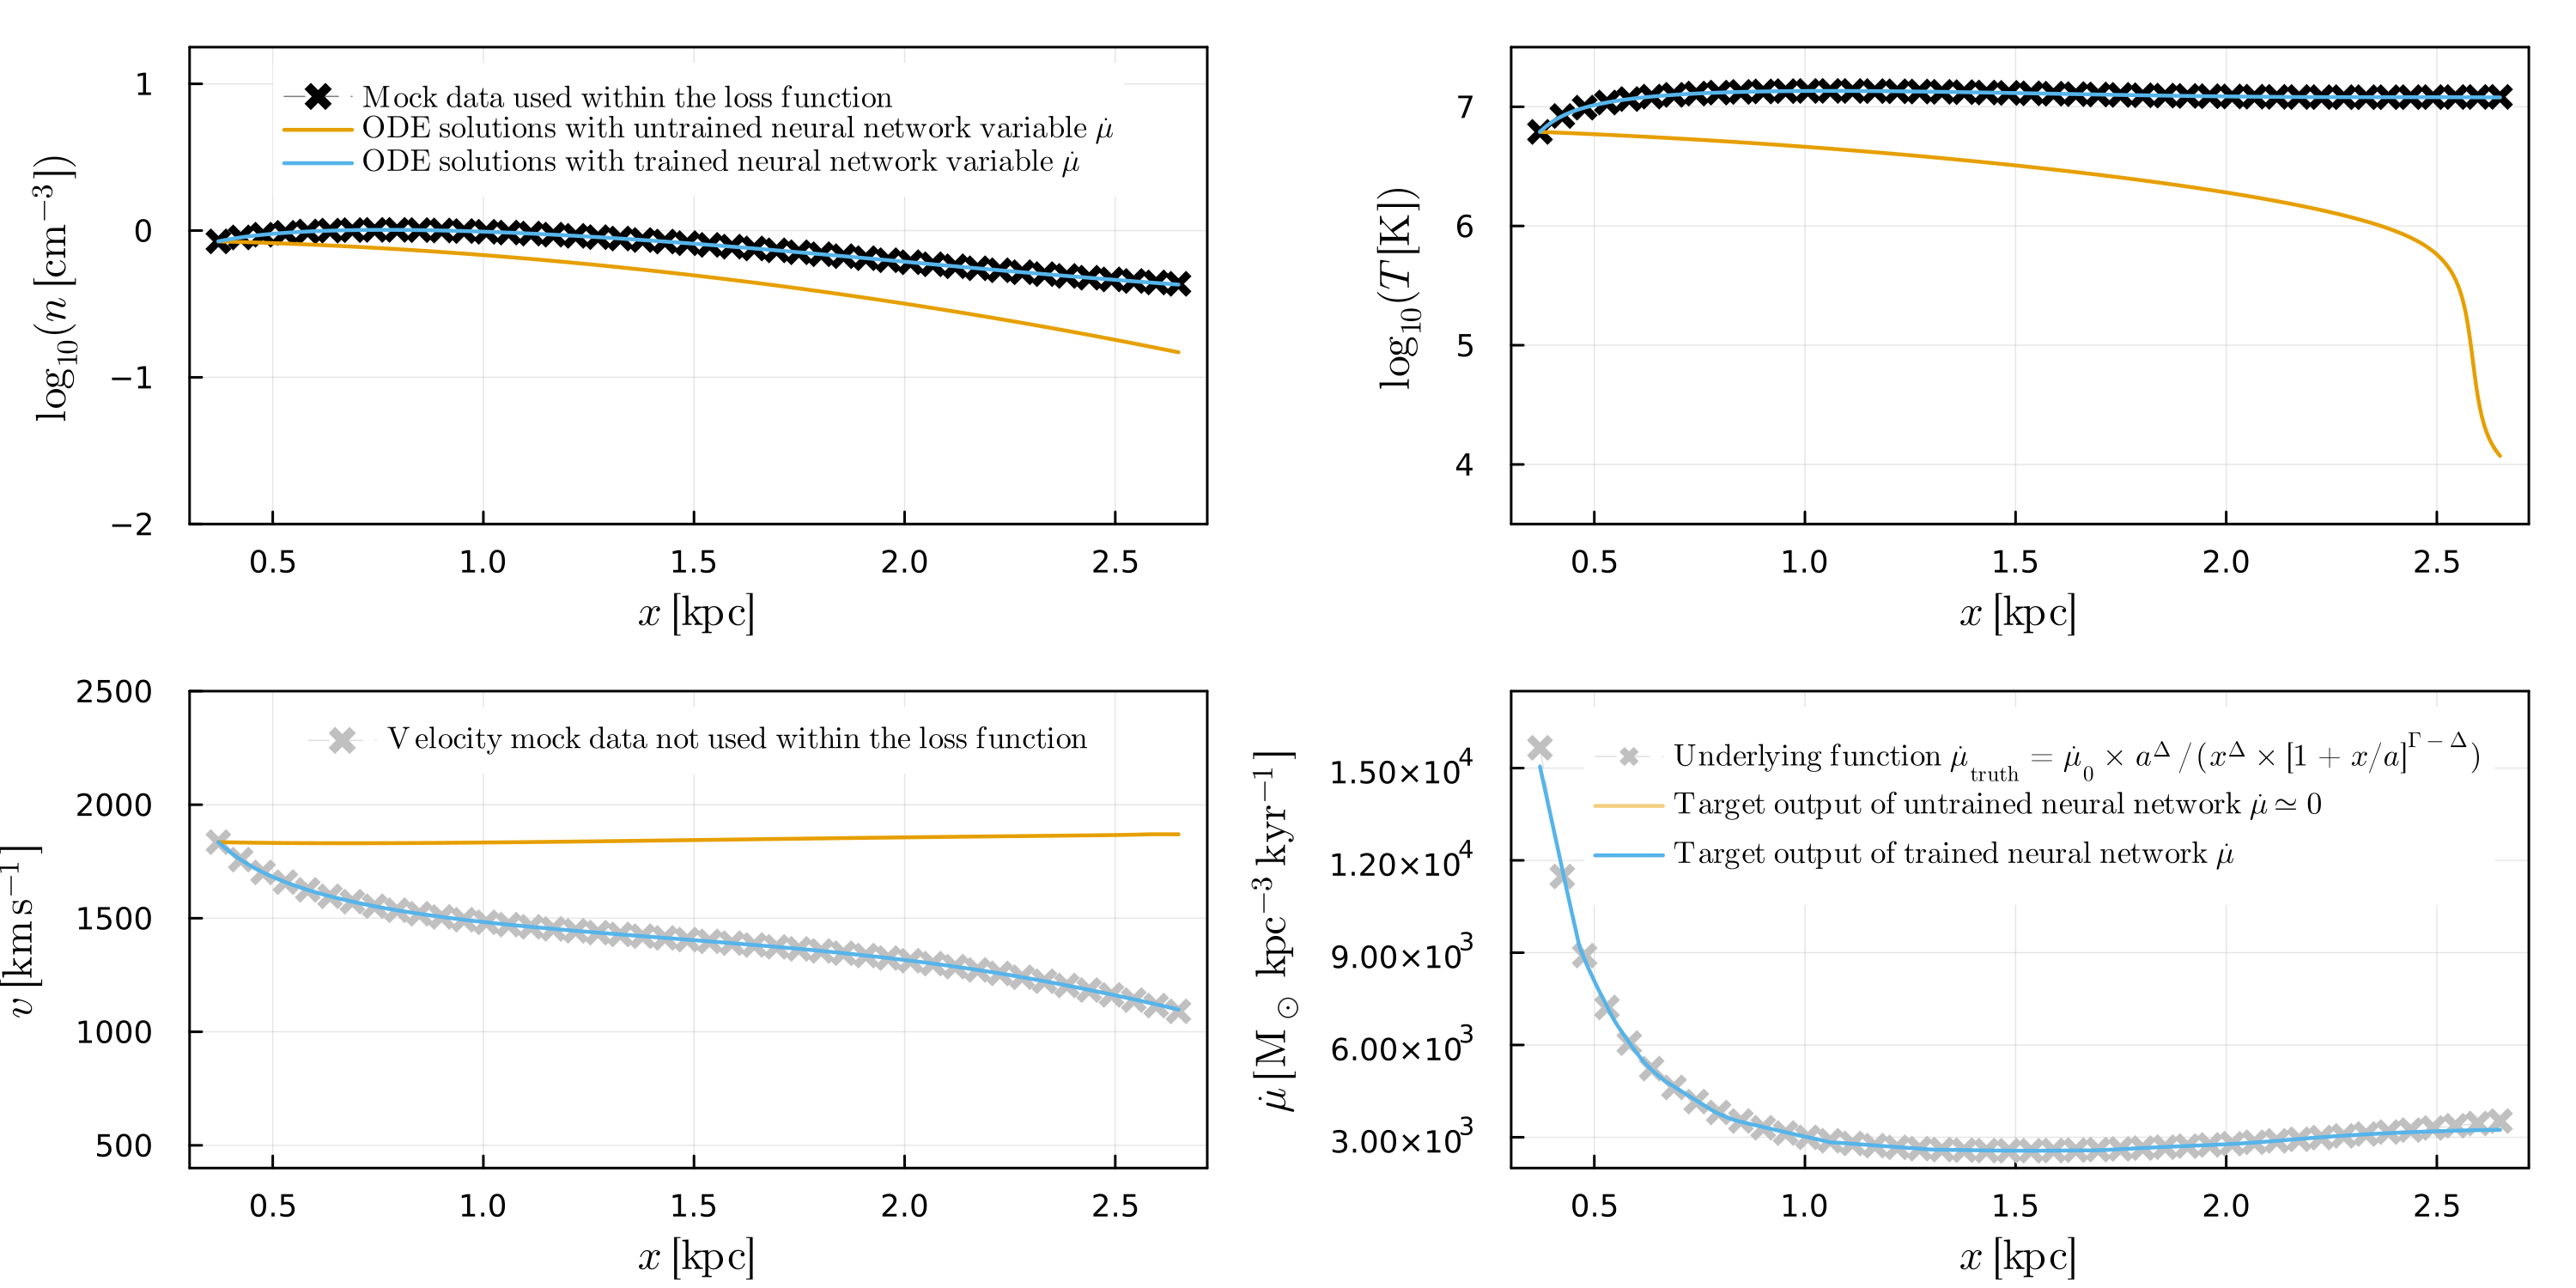

In [110]:
begin 

    framestyle = :box 
    legendfontsize = 8
    dpi = 300
    
    
    nlog_min = -2.0 
    nlog_max =  1.25
    nlog_bounds = (nlog_min,nlog_max)
    
    Tlog_min =  3.5 
    Tlog_max =  7.5
    Tlog_bounds = (Tlog_min,Tlog_max)
    
    v_min = 400
    v_max = 2500
    v_bounds = (v_min,v_max)
    
    μ_min = 2000
    μ_max = 17500
    μ_bounds = (μ_min,μ_max)
    
    xlabel  = L"$x\ \mathrm{[kpc]}$"
    ylabel1 = L"$\log_{10}(n \ \mathrm{[cm^{-3}]})$"
    ylabel2 = L"$\log_{10}(T \ \mathrm{[K]})$"
    ylabel3 = L"$v \ \mathrm{[km\,s^{-1}]}$"
    ylabel4 = L"$\dot{\mu} \ \mathrm{[M_\odot \, kpc^{-3} \, kyr^{-1}]}$"
    
    data_label   = L"$\mathrm{Mock \ data \ used \ within \ the \ loss \ function }$"
    v_data_label = L"$\mathrm{Velocity \ mock \ data \ not \ used \ within \ the \ loss \ function}$"
    adam_label   = L"$\mathrm{ODE \ solutions \ with \ untrained \ neural \ network \ variable \ } \dot{\mu}$"
    bfgs_label   = L"$\mathrm{ODE \ solutions \ with \ trained \ neural \ network \ variable \ } \dot{\mu}$"
    
    data_μ_label = L"$\mathrm{Underlying \ function \ } \dot{\mu}_\mathrm{truth} = \dot{\mu}_0 \times a^{\Delta} \, / \,  ( x^\Delta \times [1+x/a]^{\Gamma - \Delta}  )$"
    adam_μ_label = L"$\mathrm{Target \ output \ of \ untrained \ neural \ network \ } \dot{\mu} \simeq 0 $"
    bfgs_μ_label = L"$\mathrm{Target \ output \ of \ trained \ neural \ network \ } \dot{\mu}$"


    data_c = :black
    model_palette = :okabe_ito
    adam_c = 1 
    bfgs_c = 2
    
    v_data_c  = :silver
    

    
    p1 = plot(x_values,log10.(n_nonsph[indexes]),
            xlabel=xlabel,ylabel=ylabel1,label=data_label,ylim=nlog_bounds,framestyle=framestyle,
            seriestype=:scatter,marker=:x,msw=3,markeralpha=1.0,line=:path,ls=:dash,lw=0.5,linealpha=0.5,c=data_c,
            legend=:top,legendfontsize=legendfontsize,fg_legend = :transparent,dpi=dpi
            )
    plot!(x_values2,log10.(n_adam_start),palette=model_palette,lw=1.5,label=adam_label,c=adam_c)
    plot!(x_values2,log10.(n_bfgs_end),palette=model_palette,lw=1.5,label=bfgs_label,c=bfgs_c)
    


    p2 = plot(x_values,log10.(T_nonsph[indexes]),
            xlabel=xlabel,ylabel=ylabel2,label=data_label,ylim=Tlog_bounds,framestyle=framestyle,
            seriestype=:scatter,marker=:x,msw=3,markeralpha=1.0,line=:path,ls=:dash,lw=0.5,linealpha=0.5,c=data_c,
            legend=false
            )
    plot!(x_values2,log10.(T_adam_start),palette=model_palette,lw=1.5,c=adam_c)
    plot!(x_values2,log10.(T_bfgs_end),palette=model_palette,lw=1.5,c=bfgs_c)

    p3 = plot(x_values,v_nonsph[indexes]/1e5,
            xlabel=xlabel,ylabel=ylabel1,label=v_data_label,ylim=v_bounds,framestyle=framestyle,
            seriestype=:scatter,marker=:x,markercolor=v_data_c,markerstrokecolor=data_c,msw=3,markeralpha=1.0,line=:path,ls=:dash,lw=0.5,linealpha=0.5,c=v_data_c,
            legend=:top,legendfontsize=legendfontsize,fg_legend = :transparent,dpi=dpi
            )
    plot!(x_values2,v_adam_start/1e5,xlabel=xlabel,ylabel=ylabel3,palette=model_palette,lw=1.5,c=adam_c,ylim=v_bounds,framestyle=framestyle,label=false)
    plot!(x_values2,v_bfgs_end/1e5,palette=model_palette,lw=1.5,c=bfgs_c,label=false)
    
    
    p4 = plot(x_values,μ_truth[indexes],
    xlabel=xlabel,ylabel=ylabel4,label=data_μ_label,ylim=μ_bounds,framestyle=framestyle,
            seriestype=:scatter,marker=:x,markercolor=v_data_c,markerstrokecolor=data_c,msw=3,markeralpha=1.0,line=:path,ls=:dash,lw=0.5,linealpha=0.5,c=v_data_c
            )
    plot!(x_values2,μ_adam,xlabel=xlabel,ylabel=ylabel4,palette=model_palette,lw=1.5,label=adam_μ_label,c=v1_c,ylim=μ_bounds,framestyle=framestyle,alpha=0.5,
        legend=:topright,legendfontsize=legendfontsize,fg_legend = :transparent,dpi=dpi)
    plot!(x_values2,μ_bfgs,palette=model_palette,lw=1.5,label=bfgs_μ_label,c=bfgs_c)

    
    annotate!

    
    combined_plot = plot(p1, p2, p3, p4, layout=(2, 2),size=(1000,500),margin=2.65mm)
    savefig(combined_plot,workingdirectory*"plots/mock_fits.png")
    display(combined_plot)
end 

# Plot of NN learning 

v1 and v2 converged after different numbers of iterations in BFGS second round, therefore, each will need a different for loop

In [83]:
TOTAL_LOSS = vcat(LOSS_ADAM,LOSS_BFGS)
TOTAL_PRED = vcat(PRED_ADAM,PRED_BFGS)
TOTAL_PARS = vcat(PARS_ADAM,PARS_BFGS)
TOTAL_ITER = collect(1:length(TOTAL_PARS))

278-element Vector{Int64}:
   1
   2
   3
   4
   5
   6
   7
   8
   9
  10
  11
  12
  13
   ⋮
 267
 268
 269
 270
 271
 272
 273
 274
 275
 276
 277
 278

In [114]:
tester = Array([2,1,4])

for i in 1:length(TOTAL_PARS)
    
    iminus1 = i-1
    
    v_i = TOTAL_PRED[i][1,:] * VELOCITY_UNIT
    ρ_i = TOTAL_PRED[i][2,:] * DENSITY_UNIT
    P_i = TOTAL_PRED[i][3,:] * PRESSURE_UNIT
    n_i = ρ_i ./ (mu * mp)
    T_i = P_i ./ (n_i * kb)
    c_i = sqrt.(γ * P_i ./ ρ_i)
    K_i = T_i ./ n_i.^(2/3)
    M_i = v_i ./ c_i 
    
    # Grab the parameters of the NN for the given epoch iteration

    params = Array(TOTAL_PARS[i])    
    Φ = re(params)
    Φ_wrapped = x->Float64.(Φ([x]))[1]

    μdot_i = Φ_wrapped.(x_values2)
    
    
    
    
    framestyle = :box 
    legendfontsize = 8
    dpi = 300
    
    
    nlog_min = -2.0 
    nlog_max =  1.25
    nlog_bounds = (nlog_min,nlog_max)
    
    Tlog_min =  3.5 
    Tlog_max =  7.5
    Tlog_bounds = (Tlog_min,Tlog_max)
    
    v_min = 400
    v_max = 2500
    v_bounds = (v_min,v_max)
    
    μ_min = 2000
    μ_max = 17500
    μ_bounds = (μ_min,μ_max)
    
    xlabel  = L"$x\ \mathrm{[kpc]}$"
    ylabel1 = L"$\log_{10}(n \ \mathrm{[cm^{-3}]})$"
    ylabel2 = L"$\log_{10}(T \ \mathrm{[K]})$"
    ylabel3 = L"$v \ \mathrm{[km\,s^{-1}]}$"
    ylabel4 = L"$\dot{\mu} \ \mathrm{[M_\odot \, kpc^{-3} \, kyr^{-1}]}$"
    
    data_label   = L"$\mathrm{Mock \ data \ used \ within \ loss \ function }$"
    v_data_label = L"$\mathrm{Velocity \ mock \ data \ not \ used \ within \ loss \ function}$"
    adam_label   = L"$\mathrm{Prediction \ with \ untrained \ neural \ network \ variable \ } \dot{\mu}$"
    bfgs_label   = L"$\mathrm{ODE \ solutions \ with \ neural \ network \ variable \ } \dot{\mu}$"
    
    data_μ_label = L"$\dot{\mu}_\mathrm{truth} = \dot{\mu}_0 \times a^{\Delta} \, / \,  ( x^\Delta \times [1+x/a]^{\Gamma - \Delta}  )$"
    pred_μ_label = L"$\mathrm{Target \ output \ of  \ neural \ network \ } \dot{\mu}$"



    data_c = :black
    model_palette = :okabe_ito
    adam_c = 1 
    bfgs_c = 2
    
    v_data_c  = :silver
    
    ylabel_Loss = L"$\mathrm{normalized \ loss}$"
    xlabel_Loss = L"$\mathrm{iterations}$"
    
    p1 = plot(x_values,log10.(n_nonsph[indexes]),
            xlabel=xlabel,ylabel=ylabel1,label=data_label,ylim=nlog_bounds,framestyle=framestyle,
            seriestype=:scatter,marker=:x,msw=3,markeralpha=1.0,line=:path,ls=:dash,lw=0.5,linealpha=0.5,c=data_c,
            legend=:top,legendfontsize=legendfontsize,fg_legend = :transparent,dpi=dpi
            )
    plot!(x_values2,log10.(n_i),palette=model_palette,lw=1.5,label=bfgs_label,c=v1_c)


    p2 = plot(x_values,log10.(T_nonsph[indexes]),
            xlabel=xlabel,ylabel=ylabel2,label=data_label,ylim=Tlog_bounds,framestyle=framestyle,
            seriestype=:scatter,marker=:x,msw=3,markeralpha=1.0,line=:path,ls=:dash,lw=0.5,linealpha=0.5,c=data_c,
            legend=false
            )
    plot!(x_values2,log10.(T_i),palette=model_palette,lw=1.5,label=adam_v1_label,c=v1_c)

    

    p3 = plot(x_values,μ_truth[indexes],
    xlabel=xlabel,ylabel=ylabel4,label=data_μ_label,ylim=μ_bounds,framestyle=framestyle,
            seriestype=:scatter,marker=:x,markercolor=v_data_c,markerstrokecolor=data_c,msw=3,markeralpha=1.0,line=:path,ls=:dash,lw=0.5,linealpha=0.5,c=v_data_c
            )
    plot!(x_values2,μdot_i,xlabel=xlabel,ylabel=ylabel4,palette=model_palette,ylim=μ_bounds,lw=1.5,c=v1_c,label=pred_μ_label,framestyle=framestyle,
        legend=:topright,legendfontsize=legendfontsize,fg_legend = :transparent,dpi=dpi)
    annotate!(2.2, 9000, "iteration $iminus1", :black)

    p4 = plot(TOTAL_ITER[1:i],TOTAL_LOSS[1:i]/maximum(TOTAL_LOSS),label="",yscale=:log10,xlabel=xlabel_Loss,ylabel=ylabel_Loss,palette=model_palette,lw=1.5,c=v1_c,framestyle=framestyle)
    
    combined_plot = plot(p1, p2, p3, p4, layout=(2, 2),size=(1000,500),margin=4mm)
    savefig(combined_plot,workingdirectory*"plots/iters/$iminus1.png")
    #display(combined_plot) 
end

